In [ ]:
# Warning: You must have LaTeX installed to plot some graphics

[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/farneback_ME.ipynb)

# Testing 2D Farnebäck's optical flow estimator

Farnebäck estimates the dense (1x1) optical flow (with subpixel accuracy) assuming that the frames are similar in texture and the motion is smooth. In general, this last requirement generates motion fields more visually coherent and smoother that in the case of block-based ME algorithms.

In [1]:
import logging

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [3]:
!which python

/home/vruiz/envs/denoising/bin/python


In [4]:
!pip install --upgrade pip

In [5]:
import cv2

In [6]:
try:
    import scipy
except:
    !pip install scipy
    import scipy

In [7]:
try:
    import skimage
except:
    !pip install scikit-image
    import skimage

In [8]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [9]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [10]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [11]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

  Cloning https://github.com/vicente-gonzalez-ruiz/image_IO to /tmp/pip-install-_95d5tgt/image-io_b3f82c86e8a84b1e9eebd8f3b7f1547b
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/image_IO /tmp/pip-install-_95d5tgt/image-io_b3f82c86e8a84b1e9eebd8f3b7f1547b
  Resolved https://github.com/vicente-gonzalez-ruiz/image_IO to commit 841e504afd6a53018f1e7c86c3dba8a4261a989b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for image_IO: filename=image_IO-0.0.1-py3-none-any.whl size=4741 sha256=ea8179a4e96a651cbe223c516b421e9dffae9a2a4c552d86d9f32d78417440af
  Stored in directory: /tmp/pip-ephem-wheel-cache-pafnm6ti/wheels/36/0e/58/6437f30385fb075770c23f5eb637eab513662022a2ae1350d8
Successfully built image_IO


In [12]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

try:
    import motion_estimation
    #import optical_flow as motion
    #from motion_estimation import farneback
    #from motion_estimation import display
    #from motion_estimation import project
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    #from motion_estimation import farneback
    import motion_estimation
    #import display
    #import prediction
    #from motion_estimation import optical_flow as motion
    #from motion_estimation import farneback as motion_estimator
    #from motion_estimation import display
    #from motion_estimation import predict

In [ ]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

In [13]:
%%bash
if [ -d "$HOME/repos/image_synthesis" ]; then
    cd $HOME/repos/image_synthesis
    echo "$HOME/repos/image_synthesis ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_synthesis.git
fi

Cloning into 'image_synthesis'...


## Create a moving-circles sequence
There are two circles, moving horizontally in oposite directions.

In [14]:
%%bash
frames=5
~/repos/image_synthesis/moving_circle.sh -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f $frames -d 10
~/repos/image_synthesis/moving_circle.sh -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f $frames -d 10 -a 0 -b -1
set -x
i=0
while [ $i -le $((frames-1)) ]
do
    ii=$(printf "%03d" $i)
    convert -append /tmp/right${ii}.png /tmp/left${ii}.png /tmp/${ii}.png
    i=$(( $i + 1 ))
done
set -x

/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/right -x 32 -y 16 -w 64 -h 32 -f 5 -d 10
output = /tmp/right
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/right000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 33,16 43,16' -depth 8 /tmp/right001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 34,16 44,16' -depth 8 /tmp/right002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 35,16 45,16' -depth 8 /tmp/right003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 36,16 46,16' -depth 8 /tmp/right004.png
+ i=5
+ '[' 5 -le 4 ']'


/home/vruiz/repos/image_synthesis/moving_circle.sh: parsing: -o /tmp/left -x 32 -y 16 -w 64 -h 32 -f 5 -d 10 -a 0 -b -1
output = /tmp/left
Initial X coordinate = 32
Initial Y coordinate = 16
image_width = 64
image_height = 32
frames = 5
diameter = 10
Y increment = 0
X increment = -1


+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 32,16 42,16' -depth 8 /tmp/left000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 31,16 41,16' -depth 8 /tmp/left001.png
+ i=2
+ '[' 2 -le 4 ']'
++ printf %03d 2
+ ii=002
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 30,16 40,16' -depth 8 /tmp/left002.png
+ i=3
+ '[' 3 -le 4 ']'
++ printf %03d 3
+ ii=003
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 29,16 39,16' -depth 8 /tmp/left003.png
+ i=4
+ '[' 4 -le 4 ']'
++ printf %03d 4
+ ii=004
+ convert -size 64x32 xc:skyblue -fill white -stroke black -draw 'circle 28,16 38,16' -depth 8 /tmp/left004.png
+ i=5
+ '[' 5 -le 4 ']'
+ i=0
+ '[' 0 -le 4 ']'
++ printf %03d 0
+ ii=000
+ convert -append /tmp/right000.png /tmp/left000.png /tmp/000.png
+ i=1
+ '[' 1 -le 4 ']'
++ printf %03d 1
+ ii=001


## Testing with moving circles (max_abs_motion=1)

In [15]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/001.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

[image_3.py:39 read() INFO] /tmp/000.png (64, 64, 3) uint8 len=558 max=255 min=0
[image_3.py:39 read() INFO] /tmp/001.png (64, 64, 3) uint8 len=558 max=255 min=0


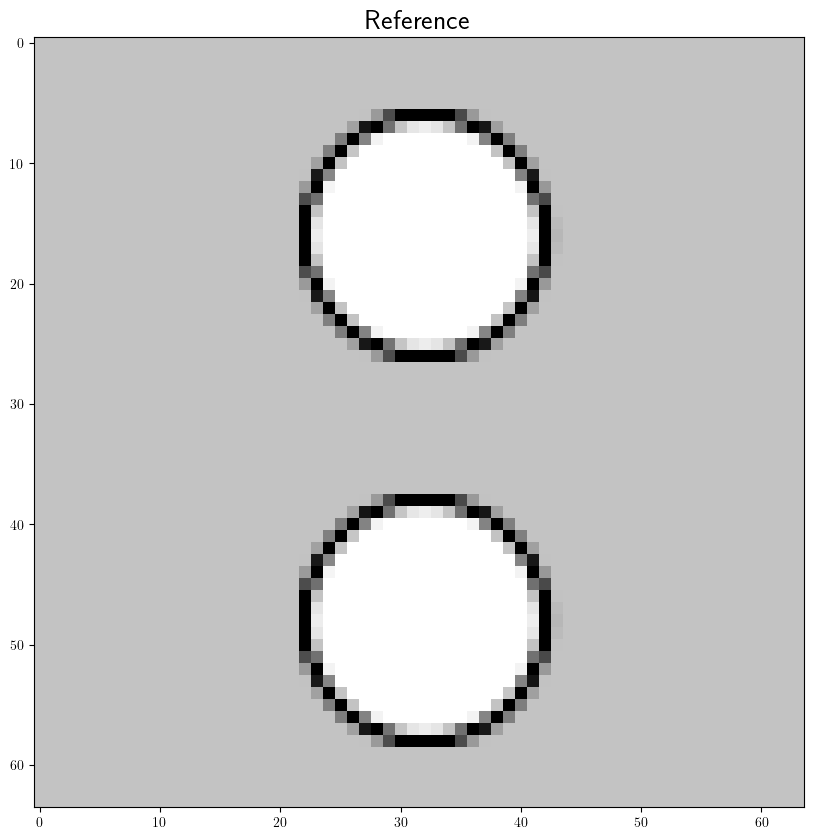

In [16]:
gray_image.show(R_Y, "Reference")

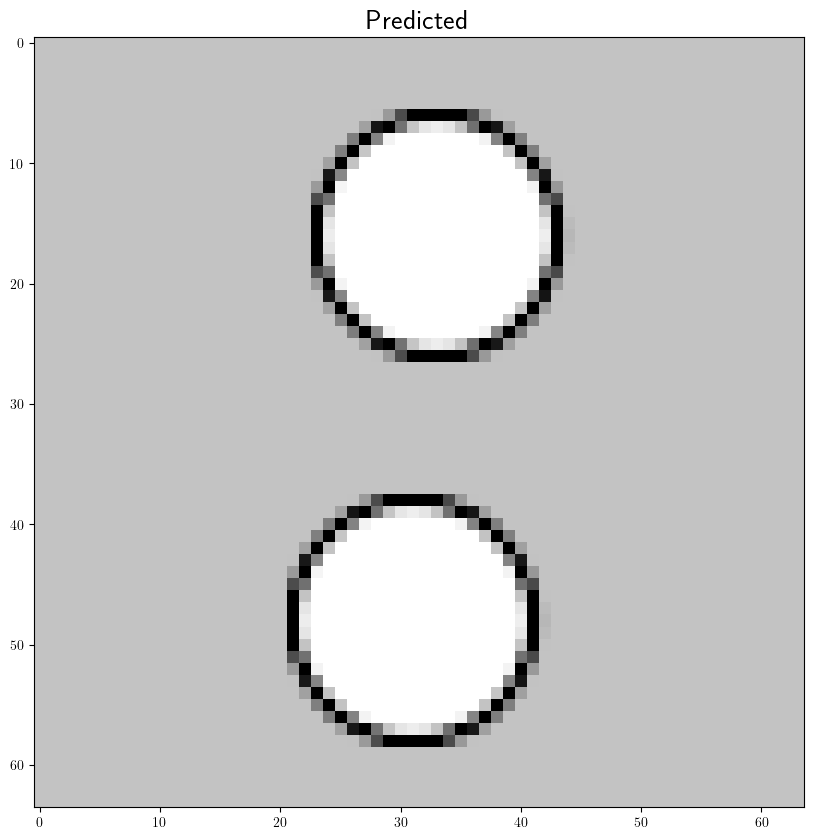

In [17]:
gray_image.show(P_Y, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [18]:
from motion_estimation._2D.farneback_OpenCV import OF_Estimation
#from motion_estimation._2D.farneback_python import Farneback as Estimator
from motion_estimation._2D.helpers import show_vectors
from motion_estimation._2D.project import Projection

In [19]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
estimator = OF_Estimation()
MVs = estimator.pyramid_get_flow(target=P_Y, reference=R_Y, flow=initial_MVs)
#MVs = MVs.astype(np.float32)

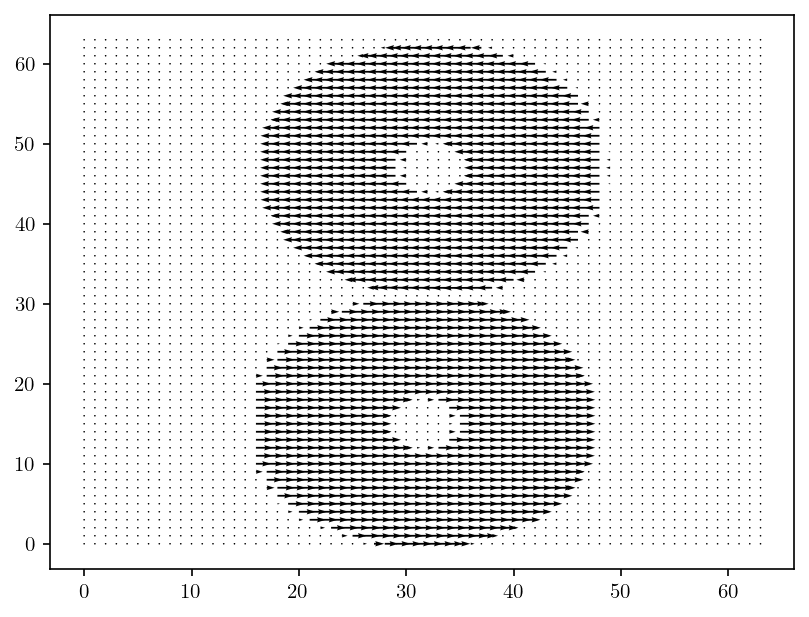

In [20]:
show_vectors(MVs[::1, ::1])

In [21]:
#hat_P = predict.warp(reference=R, flow=MVs)
projector = Projection()
hat_P = projector.remap(R, MVs)
#MVs += np.moveaxis(np.indices(R_Y.shape), 0, -1)
#hat_P = skimage.transform.warp(R, np.moveaxis(MVs, -1, 0), cval=np.nan, preserve_range=True)


Function: remap
self: <motion_estimation._2D.project.Projection object at 0x7f53e5d2e6c0>
slice.shape: (64, 64, 3) 0 193.8974609375 255
flow.shape: (64, 64, 2) -1.0002541542053223 -0.00024552643299102783 1.0008838176727295
interpolation_mode: 1
extension_mode: 1


In [22]:
print(R.dtype, MVs.dtype)

uint8 float32


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_444845/2483718814.py:1: SyntaxWarning: invalid escape sequence '\m'
  RGB_image.show(R, "reference ${\mathbf R}$")
/tmp/ipykernel_444845/2483718814.py:2: SyntaxWarning: invalid escape sequence '\h'
  RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
/tmp/ipykernel_444845/2483718814.py:3: SyntaxWarning: invalid escape sequence '\h'
  RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")
[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=146.75390625
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=205.47607421875
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=229.46240234375
[image_3.py:87 print_

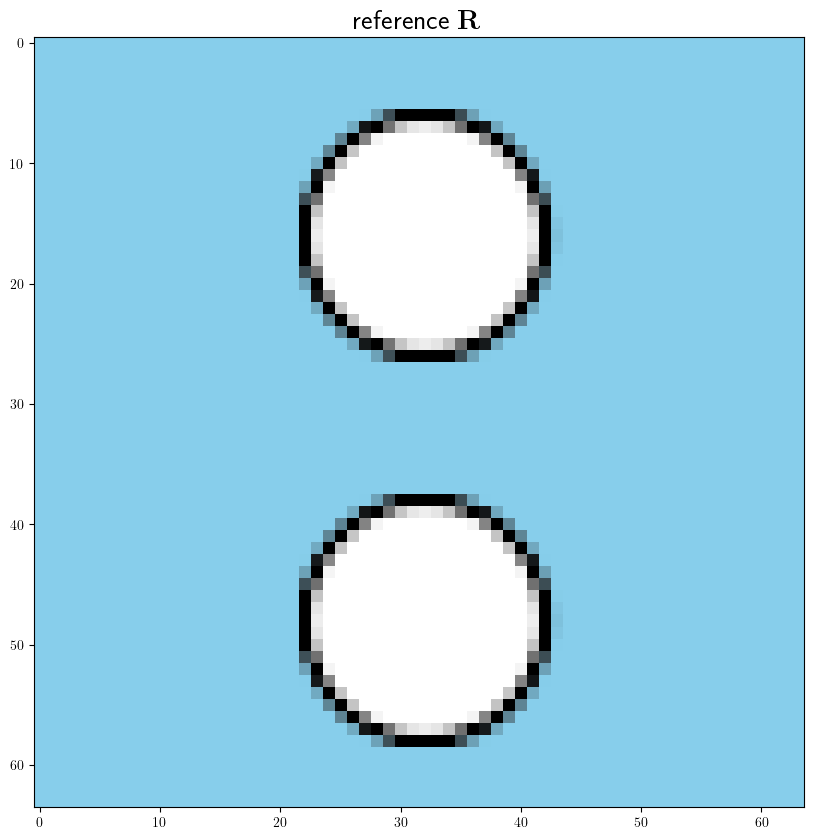

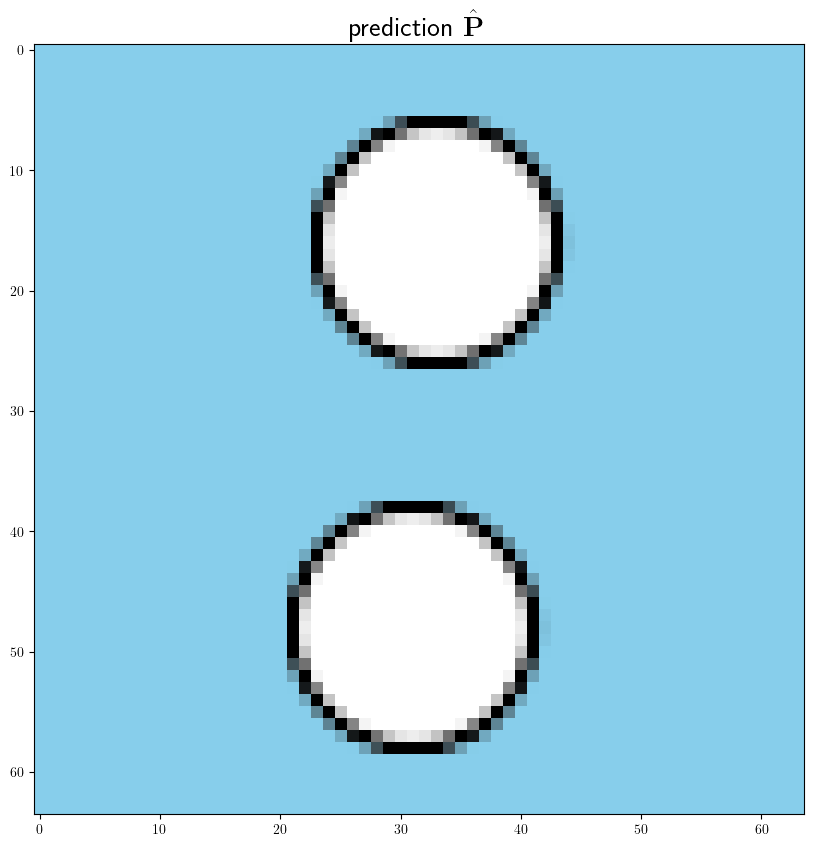

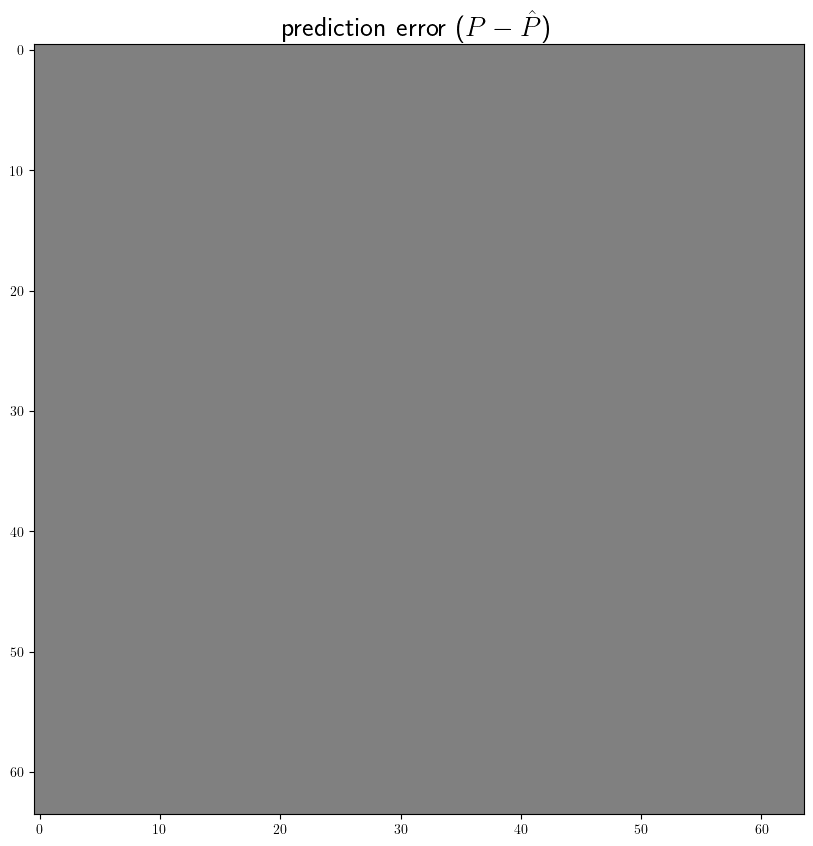

In [23]:
RGB_image.show(R, "reference ${\mathbf R}$")
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Testing with moving circles (max_abs_motion=2)

In [ ]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/002.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [ ]:
gray_image.show(R_Y, "reference ${\mathbf R}$")
gray_image.show(P_Y, "predicted ${\mathbf P}$")

In [ ]:
#initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#estimator = farneback.Estimator_in_CPU()
MVs = estimator.pyramid_get_flow(target=P_Y, reference=R_Y, flow=initial_MVs)

In [ ]:
show_vectors(MVs[::1, ::1])

In [ ]:
hat_P = projector.remap(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Even more distance

In [ ]:
R = RGB_image.read("/tmp/000.png")
P = RGB_image.read("/tmp/004.png")
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [ ]:
gray_image.show(R, "reference ${\mathbf R}$")
gray_image.show(P, "predicted ${\mathbf P}$")

In [ ]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
#initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#estimator = farneback.Estimator_in_CPU()
MVs = estimator.pyramid_get_flow(target=P_Y, reference=R_Y, flow=initial_MVs)

In [ ]:
show_vectors(MVs[::1, ::1])

In [ ]:
hat_P = projector.remap(R, MVs)
RGB_image.show(hat_P, "prediction $\hat{\mathbf P}$")
RGB_image.show((P - hat_P + 128).astype(np.uint8), "prediction error ($P-\hat{P}$)")

## Tile of Stockholm

In [ ]:
%%bash
URL="https://hpca.ual.es/~vruiz/videos/"
sequence="stockholm_1280x768x50x420x578.avi"
output_prefix="/tmp/original_"
number_of_frames=16
first_frame=2
~/repos/image_synthesis/extract_frames.sh -u $URL -s $sequence -o $output_prefix -n $number_of_frames -f $first_frame

In [ ]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
sequence = "/tmp/original_"
R = RGB_image.read(sequence + "003.png")[slice_Y, slice_X]
P = RGB_image.read(sequence + "004.png")[slice_Y, slice_X]

In [ ]:
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

In [ ]:
initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
MVs = estimator.pyramid_get_flow(target=P_Y, reference=R_Y, flow=initial_MVs)

In [ ]:
MVs.dtype

In [ ]:
entropy = information.entropy(MVs.flatten())
show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

In [ ]:
hat_P = projector.remap(R, MVs)
RGB_image.show(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
RGB_image.show(P_hat_P.astype(np.uint8), "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")

Notice that Farneback provides subpixel accuracy.

## Testing a Python implementation of Farneback
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [ ]:
#import importlib

In [ ]:
from motion_estimation._2D.farneback_python import OF_Estimation

In [ ]:
#import motion_estimation._2D.farneback_python

# Use importlib to reload the module
#importlib.reload(motion_estimation._2D.farneback_python)

In [ ]:
estimator = OF_Estimation()
MVs = estimator.pyramid_get_flow(P_Y, R_Y)

In [ ]:
#f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), cval=np.nan, preserve_range=True)
projector = Projection()
hat_P_Y = projector.remap(R_Y, MVs)

In [ ]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)

In [ ]:
plt.imshow(hat_P_Y, cmap=cmap)

In [ ]:
plt.imshow(P_Y - hat_P_Y, cmap=cmap)

In [ ]:
hat_P_Y.dtype

In [ ]:
entropy = information.entropy(MVs.flatten())
show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

In [ ]:
MVs.shape

## Testing with a synthetic image

In [ ]:
x = np.linspace(-5, 5, 100)
sigma = 1.0
mu = 0.0

# Create a 2D meshgrid
X, Y = np.meshgrid(x, x, indexing='ij')

# Compute the 3D Gaussian function
img = np.exp(-((X - mu)**2 + (Y - mu)**2) / (2 * sigma**2))

# Alternatively, if you want to use the 1D sampled Gaussian array in each dimension:
# This creates a 3D array by multiplying the 1D Gaussian arrays in each dimension
#gaussian_3d = gaussian_1d[:, None, None] * gaussian_1d[None, :, None] * gaussian_1d[None, None, :]

print(img.shape)

In [ ]:
estimator = OF_Estimation(logging_level=logging.DEBUG)
flow = estimator.pyramid_get_flow(target=img, reference=img)

## OpenCV vs ericPrince
https://github.com/ericPrince/optical-flow/blob/master/optical_flow.py

In [ ]:
import numpy as np
import scipy.ndimage
from functools import partial
import skimage.io
import skimage.transform

__all__ = ["__version__", "poly_exp", "flow_iterative"]


__version__ = "1.0.0"


def poly_exp(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 2D signal, as described by Farneback
    Uses separable normalized correlation
    $f ~ x^T A x + B^T x + C$
    If f[i, j] and c[i, j] are the signal value and certainty of pixel (i, j) then
    A[i, j] is a 2x2 array representing the quadratic term of the polynomial, B[i, j]
    is a 2-element array representing the linear term, and C[i, j] is a scalar
    representing the constant term.
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Calculate applicability kernel (1D because it is separable)
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", )
    a = np.exp(-(x**2) / (2 * sigma**2))  # a: applicability kernel [n]
    print("a =", a)

    # b: calculate b from the paper. Calculate separately for X and Y dimensions
    # [n, 6]
    bx = np.stack(
        [np.ones(a.shape), x, np.ones(a.shape), x**2, np.ones(a.shape), x], axis=-1
    )
    print("bx =", bx)
    by = np.stack(
        [
            np.ones(a.shape),
            np.ones(a.shape),
            x,
            np.ones(a.shape),
            x**2,
            x,
        ],
        axis=-1,
    )
    print("by =", by)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("c =", c)
    print("f =", f)
    print("cf =", cf)

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, bx)
    abb = np.einsum("ij,ik->ijk", ab, bx)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, by)
    abb = np.einsum("ij,ik->ijk", ab, by)
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab[..., i], axis=1, mode="constant", cval=0
        )

    # Solve r for each pixel
    r = np.linalg.solve(G, v)

    # Quadratic term
    A = np.empty(list(f.shape) + [2, 2])
    A[..., 0, 0] = r[..., 3]
    A[..., 0, 1] = r[..., 5] / 2
    A[..., 1, 0] = A[..., 0, 1]
    A[..., 1, 1] = r[..., 4]

    # Linear term
    B = np.empty(list(f.shape) + [2])
    B[..., 0] = r[..., 1]
    B[..., 1] = r[..., 2]

    # constant term
    C = r[..., 0]

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f
    print("A =", A)
    print("B =", B)
    print("C =", C)
    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)

    return A, B, C


def flow_iterative(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the images
    A1, B1, C1 = poly_exp(f1, c1, sigma)
    A2, B2, C2 = poly_exp(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.stack(
        np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])),
        axis=-1,
    ).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [2])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
          
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

def OF(f1, f2): # f1 and f2 double's
    # certainties for images - certainty is decreased for pixels near the edge
    # of the image, as recommended by Farneback

    # c1 = np.ones_like(f1)
    # c2 = np.ones_like(f2)

    c1 = np.minimum(
        1, 1 / 5 * np.minimum(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1]))
    )
    c1 = np.minimum(
        c1,
        1
        / 5
        * np.minimum(
            f1.shape[0] - 1 - np.arange(f1.shape[0])[:, None],
            f1.shape[1] - 1 - np.arange(f1.shape[1]),
        ),
    )
    c2 = c1

    # ---------------------------------------------------------------
    # calculate optical flow with this algorithm
    # ---------------------------------------------------------------

    n_pyr = 4

    # # version using perspective warp regularization
    # # to clean edges
    # opts = dict(
    #     sigma=4.0,
    #     sigma_flow=4.0,
    #     num_iter=3,
    #     model='eight_param',
    #     mu=None,
    # )

    # version using no regularization model
    opts = dict(
        sigma=4.0,
        sigma_flow=4.0,
        num_iter=3,
        model="constant",
        mu=0,
    )

    # optical flow field
    d = None

    # calculate optical flow using pyramids
    # note: reversed(...) because we start with the smallest pyramid
    for pyr1, pyr2, c1_, c2_ in reversed(
        list(
            zip(
                *list(
                    map(
                        partial(skimage.transform.pyramid_gaussian, max_layer=n_pyr),
                        [f1, f2, c1, c2],
                    )
                )
            )
        )
    ):
        if d is not None:
            # TODO: account for shapes not quite matching
            #d = skimage.transform.pyramid_expand(d, multichannel=True)
            d = skimage.transform.pyramid_expand(d, channel_axis=2)
            d = d[: pyr1.shape[0], : pyr2.shape[1]]

        d = flow_iterative(pyr1, pyr2, c1=c1_, c2=c2_, d=d, **opts)

    xw = d + np.moveaxis(np.indices(f1.shape), 0, -1)
    return xw

In [ ]:
MVs = OF(P_Y, R_Y)
f2_w = skimage.transform.warp(R_Y, np.moveaxis(MVs, -1, 0), preserve_range=True)

In [ ]:
cmap = "gray"
plt.imshow(R_Y, cmap=cmap)

In [ ]:
np.max(R_Y)

In [ ]:
plt.imshow(np.nan_to_num(f2_w), cmap=cmap)

In [ ]:
np.max(np.nan_to_num(f2_w))

## Working with lines
Farneback requires at least 2 lines, that in this case are true lines extracted from the image.

In [ ]:
# From row 100 to row 355 (both included), we take 3 columns that go from 100 to 102 (both included)
R = RGB_image.read(sequence + "003.png")[100:356,100:103]
P = RGB_image.read(sequence + "003.png")[100:356,104:107]
#P = np.roll(R, 2)

In [ ]:
R = np.swapaxes(R, 0, 1)
P = np.swapaxes(P, 0, 1)

In [ ]:
R.shape

In [ ]:
P.shape

In [ ]:
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]

In [ ]:
print(R_Y, P_Y)

In [ ]:
print(R_Y.shape, P_Y.shape)

In [ ]:
#initial_MVs = np.zeros((P_Y.shape[0], P_Y.shape[1], 2), dtype=np.float32)
#MVs = motion.Farneback_ME(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)
MVs = estimator.get_flow(target=P_Y, reference=R_Y, prev_flow=initial_MVs)

In [ ]:
print(np.max(MVs), np.min(MVs))

In [ ]:
R_Y.shape

In [ ]:
#gray_image.show(np.stack([R_Y, R_Y, R_Y, P_Y, P_Y, P_Y]), size=(30,10))
gray_image.show(np.stack([R_Y, P_Y], axis=0).reshape(6, 256), size=(30,10))


In [ ]:
MVs.shape

In [ ]:
motion_estimation.helpers.show_vectors(MVs)

In [ ]:
img = RGB_image.read(sequence + "015.png")[100:356, 100:456]
RGB_image.show(img,"")
print(img.dtype)

In [ ]:
#!export OPENCV_LOG_LEVEL=DEBUG

def filter_AAABBB(Y_img):
    # Iterate over rows
    total_flow_through_rows = []
    flow = np.zeros((3, Y_img.shape[1], 2), dtype=np.float32)
    for y in range(Y_img.shape[0]-1):
        prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #prev = np.stack([Y_img[y], Y_img[y+1], Y_img[y]])
        next = np.stack([Y_img[y+1], Y_img[y+1], Y_img[y+1]])
        #print(prev)
        if y==10:
            print(prev.shape, next.shape, flow.shape)
            print(np.max(prev), np.max(next))
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_rows.append(flow[1])
    # Iterate over columns
    total_flow_through_cols = []
    flow = np.zeros((3, Y_img.shape[0], 2), dtype=np.float32)
    for x in range(Y_img.shape[1]-1):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, x+1], Y_img[:, x+1], Y_img[:, x+1]])
        flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_through_cols.append(flow[1])
    return np.stack(total_flow_through_rows), np.stack(total_flow_through_cols)

N = 5

def filter_AAABBB(Y_img):
    print(np.average(Y_img))
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        #prev = np.stack([Y_img[y], Y_img[(y+1)%N_rows], Y_img[(y+2)%N_rows]])
        #next = np.stack([Y_img[(y+3)%N_rows], Y_img[(y+4)%N_rows], Y_img[(y+5)%N_rows]])
        #prev = np.stack([Y_img[y], Y_img[y], Y_img[y]])
        #next = np.stack([Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows], Y_img[(y+1)%N_rows]])
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        assert prev.shape==next.shape, f"{c} {prev.shape} {next.shape}"
        #print(prev)
        #print(next)
        #print(prev)
        #if y==10:
        #    print(prev.shape, next.shape, flow[1].shape)
        #    print(np.max(prev), np.max(next))
        #    print(np.max(Y_img[y]), np.max(Y_img))
        #    print(prev, next)
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=prev_flow, wside=N)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #prev_flow = flow.copy()
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(flow.shape)
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        total_flow_rows_pass.append(flow[N>>1][..., 0])
        #print(flow[0], total_flow_rows_pass)
        max = 0
        for i in total_flow_rows_pass:
            _max = np.max(np.abs(i))
            if _max > max:
                max = _max
        #print("max=", max)
        c += 1
    #print(len(total_flow_rows_pass))
    #print(total_flow_rows_pass)
    #for i in total_flow_rows_pass:
    #    if np.max(np.abs(i)) != 0.0:
    #        print("!", end='')
    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    print("max=", np.max(np.abs(total_flow_rows_pass)))
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((N, Y_img.shape[0], 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = np.stack([Y_img[:, x], Y_img[:, x], Y_img[:, x]])
        next = np.stack([Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols], Y_img[:, (x+1)%N_cols]])
        #prev = np.stack([Y_img[:, x], Y_img[:, (x+1)%N_cols], Y_img[:, (x+2)%N_cols]])
        #next = np.stack([Y_img[:, (x+3)%N_cols], Y_img[:, (x+4)%N_cols], Y_img[:, (x+4)%N_cols]])
        #flow = motion.Farneback_ME(predicted=next, reference=prev, initial_MVs=flow, wside=3)
        total_flow_cols_pass.append(flow[N>>1][..., 1])
    #total_flow_cols_pass = np.stack(total_flow_cols_pass)
    total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

def get_fields(Y_img):
    extended_img = np.zeros(shape=(Y_img.shape[0]+N, Y_img.shape[1]+N), dtype=Y_img.dtype)
    extended_img[N//2:Y_img.shape[0]+N//2, N//2:Y_img.shape[1]+N//2] = Y_img[:, :]
    # Iterate over rows
    total_flow_rows_pass = []
    prev_flow = np.zeros((N, Y_img.shape[1], 2), dtype=np.float32)
    N_rows = Y_img.shape[0]
    c = 0
    for y in range(N_rows):
        prev = extended_img[y:y+N]
        #next = np.roll(prev, 1, axis=1)
        next = extended_img[y+1:y+1+N]
        #prev_flow = flow.copy()
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #flow = np.random.rand(flow.size).reshape(flow.shape).astype(np.float32)
        #print(c, np.max(np.abs(flow[N>>1][..., 0])), np.max(np.abs(flow[N>>1][..., 1])))
        #print(np.unravel_index(np.argmax(abs(flow[1])), flow[1].shape), np.max(abs(flow[1])), end=' ')
        #total_flow_rows_pass.append(flow[N>>1][..., 0])
        total_flow_rows_pass.append(flow[(N>>1) + 1, :, 0])
        c += 1

    #total_flow_rows_pass = np.array(total_flow_rows_pass).reshape((Y_img.shape[0], Y_img.shape[1]))
    total_flow_rows_pass = np.stack(total_flow_rows_pass)
    # Iterate over columns
    total_flow_cols_pass = []
    flow = np.zeros((Y_img.shape[0], N, 2), dtype=np.float32)
    N_cols = Y_img.shape[1]
    for x in range(N_cols):
        prev = extended_img[..., x:x+N]
        next = extended_img[..., x+1:x+1+N]
        #print(prev.shape, next.shape)
        flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=None,
                                            pyr_scale=0.5, levels=0, winsize=N,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
        #print(flow[..., N>>1, 1].shape)
        total_flow_cols_pass.append(flow[..., (N>>1) + 1, 1])
    total_flow_cols_pass = np.stack(total_flow_cols_pass, axis=1)
    #total_flow_cols_pass = np.array(total_flow_cols_pass).reshape(Y_img.shape)
    return total_flow_rows_pass, total_flow_cols_pass

In [ ]:
Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:105,100:107])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:125])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:225,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:625,100:625])
#flow_rows, flow_cols = filter_AAABBB(Y_img[10:758,10:1270])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:125,100:225])
#flow_rows, flow_cols = filter_AAABBB(Y_img[100:668,100:1180])
#flow_rows, flow_cols = filter_AAABBB(Y_img[40:740,40:1170])
#flow_rows, flow_cols = filter_AAABBB(Y_img)
flow_rows, flow_cols = get_fields(Y_img)

In [ ]:
768*1280

In [ ]:
flow_rows.shape

In [ ]:
flow_cols.shape

In [ ]:
np.max(flow_rows)

In [ ]:
768*1280

In [ ]:
np.min(flow_rows)

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows, cmap="gray")

In [ ]:
matplotlib.pyplot.imshow(X=flow_cols, cmap="gray")

In [ ]:
gray_image.show(flow_rows*255,"")

In [ ]:
gray_image.show(flow_cols*255,"")

In [ ]:
def get_flow(prev, next, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=prev, next=next, flow=prev_flow,
                                        pyr_scale=0.5, levels=l, winsize=w,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)
    return flow[(N>>1) + 1, :, 0]

In [ ]:
def vertical_filtering(img, kernel):
    KS = kernel.size
    KS2 = KS//2
    extended_img = np.zeros(shape=(img.shape[0] + KS, img.shape[1] + KS), dtype=img.dtype)
    extended_img[KS2:img.shape[0] + KS2, KS2:img.shape[1] + KS2] = img[:, :]
    N_rows = img.shape[0]
    tmp_slice = np.zeros(shape=(img.shape[1]))
    for y in range(N_rows):
        for i in range(KS2 - 1, -1, -1):
            prev = extended_img[y:y + w]
            next = extended_img[y + 1:y + 1 + w]
            flow = get_flow(prev, next, l, w, None)

# 2D Gaussian filtering

In [ ]:
import time

def vertical_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0] + KL, img.shape[1]))
    extended_img[KL2:img.shape[0] + KL2, :] = img[:, :]
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            horizontal_line += extended_img[y + i, :] * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def horizontal_gaussian_filtering(img, kernel, mean):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL))
    extended_img[:, KL2:img.shape[1] + KL2] = img[:, :]
    #filtered_img = []
    filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    vertical_line = np.empty(N_rows, dtype=np.float32)
    for x in range(N_cols):
        #vertical_line = np.zeros(N_rows, dtype=np.float32)
        vertical_line.fill(0)
        for i in range(KL):
            vertical_line += extended_img[:, x + i] * kernel[i]
        #filtered_img.append(vertical_line)
        filtered_img[:, x] = vertical_line[:]
    #filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def gaussian_filtering(img, kernel):
    mean = np.average(img)
    t0 = time.perf_counter()
    filtered_img_Y = vertical_gaussian_filtering(img, kernel, mean)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_YX = horizontal_gaussian_filtering(filtered_img_Y, kernel, mean)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_YX

def gaussian_kernel(sigma):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

def color_gaussian_filtering(img, kernel):
    filtered_img_R = gaussian_filtering(img[..., 0], kernel)
    filtered_img_G = gaussian_filtering(img[..., 1], kernel)
    filtered_img_B = gaussian_filtering(img[..., 2], kernel)
    return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2)

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(filtered_img.astype(np.uint8),"")

# 2D OF-driven Gaussian filtering

In [ ]:

def horizontal_OF_gaussian_filtering(img, kernel, mean=128, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_img = np.full(fill_value=mean, shape=(img.shape[0], img.shape[1] + KL + 2*w, img.shape[2]))
    extended_img[:, KL2 + w:img.shape[1] + KL2 + w] = img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference = extended_img[:, x + i    :x + i     + w] 
            target    = extended_img[:, x + i + 1:x + i + 1 + w]
            flow = get_flow(target, reference, l, w, None)
            #OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]

        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    return filtered_img

def vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l=3 , w=5):
    KL = kernel.size
    KL2 = KL//2
    extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1]))
    extended_Y_img[KL2 + w:Y_img.shape[0] + KL2 + w, :] = Y_img[:, :]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    flow_rows = []
    for y in range(N_rows):
        horizontal_line = np.zeros(N_cols, dtype=np.float32)
        for i in range(KL):
            #reference = extended_img[y + i    :y + i     + w, :] 
            #target    = extended_img[y + i + 1:y + i + 1 + w, :]
            reference = extended_img[y    :y     + w, :] 
            target    = extended_img[y + i:y + i + w, :]
            #assert reference.shape == target.shape, f"{reference.shape} {target.shape}"
            flow = get_flow(target, reference, l, w, None)
            #flow = get_flow(reference, target, l, w, None)
            OF_compensated_slice = warp_slice(reference, flow)
            #OF_compensated_slice = warp_slice(target, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
            if i==0: #i==(KL-1):
                flow_rows.append(flow[(w + 1)>>1, :, 0])
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    flow_rows = np.stack(flow_rows)
    return filtered_img, flow_rows


def OF_gaussian_filtering(Y_img, img, kernel, l=3, w=5):
    mean = [np.average(img)[..., 0], np.average(img)[..., 1], np.average(img)[..., 2]]
    t0 = time.perf_counter()
    filtered_img_y, _ = vertical_OF_gaussian_filtering(Y_img, img, kernel, mean, l , w)
    t1 = time.perf_counter()
    print(t1 - t0)
    filtered_img_yx = horizontal_OF_gaussian_filtering(Y_img, filtered_img_y, kernel, mean, l , w)
    #filtered_img_YX = horizontal_OF_gaussian_filtering(img, kernel, mean, l , w)
    t2 = time.perf_counter()
    print(t2 - t1)
    return filtered_img_yx, _

def color_OF_gaussian_filtering(img, kernel, l=3, w=5):
    Y_img = YUV.from_RGB(img.astype(np.int16))[..., 0]
    filtered_img,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_G,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #filtered_img_B,_ = OF_gaussian_filtering(Y_img, img, kernel, l , w)
    #return np.stack([filtered_img_R, filtered_img_G, filtered_img_B], axis=2), flow_rows
    return filtered_img

In [ ]:
def warp_slice(reference, flow):
    height, width = flow.shape[:2]
    map_x = np.tile(np.arange(width), (height, 1))
    map_y = np.swapaxes(np.tile(np.arange(height), (width, 1)), 0, 1)
    map_xy = (flow + np.dstack((map_x, map_y))).astype('float32')
    warped_slice = cv2.remap(reference, map_xy, None,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return warped_slice

def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=1.2,
                                            flags=0)
    return flow

def OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    
    # Filtering along the vertical direction
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        for i in range(KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_vertical_slice = warp_slice(reference_slice, flow)
            OF_compensated_vertical_line = OF_compensated_vertical_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        horizontal_line += img[y, :, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference_slice = img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)    
    filtered_img = np.stack(filtered_img, axis=0)
    
    img = filtered_img
    
    # Horizontal direction
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(shape=(N_rows, img.shape[2]), dtype=np.float32)
        reference_slice_Y = Y[:, x:x + w] 
        for i in range(KL2):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        vertical_line += img[:, x, :] * kernel[KL2]
        for i in range(KL2 + 1, KL):
            target_slice_Y = Y[:, x + i:x + i + w]
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            reference = img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1, :]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img

def _OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    #Y_mean = np.average(Y_img)[..., 0]
    # Signal extension?
    #extended_Y_img = np.full(fill_value=mean[0], shape=(Y_img.shape[0] + KL + 2*w, Y_img.shape[1] + KL + 2*w))
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2 + w:Y.shape[0] + KL2 + w2, KL2 + w:Y.shape[1] + KL2 + w2] = Y[...]
    #extended_img = np.full(fill_value=mean[0], shape=(img.shape[0] + KL + 2*w, img.shape[1] + KL + 2*w, img.shape[3]))
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + KL + 2*w, img.shape[0] + KL + 2*w))
    extended_img[KL2 + w:img.shape[0] + KL2 + w2, KL2 + w:img.shape[1] + KL2 + w2] = img[...]
    print(extended_img.shape)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Vertical
    filtered_img = []
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        for i in range(0, KL2):
            target_slice_Y = extended_Y[y + i:y + i + w, :]
        for i in range(KL):
            # For i=0, the flow==0, and this case can be out of the loop
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            #reference = extended_img[y:y + w, :]
            reference = extended_img[y:y + w, :]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            print(reference.shape, OF_compensated_slice.shape, OF_compensated_line.shape)
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)
    
    extended_img[KL2 + w:img.shape[0] + KL2 + w, KL2 + w:img.shape[1] + KL2 + w] = filtered_img[...]
    
    # Horizontal
    filtered_img = []
    for x in range(N_cols):
        vertical_line = np.zeros(N_rows, dtype=np.float32)
        for i in range(KL):
            reference_Y = extended_Y[:, x    :x +   + w] 
            target_Y    = extended_Y[:, x + i:x + i + w]
            flow = get_flow(target_Y, reference_Y, l, w, None)
            reference = extended_img[:, x:x + w]
            OF_compensated_slice = warp_slice(reference, flow)
            OF_compensated_line = OF_compensated_slice[: , (w + 1) >> 1]
            vertical_line += OF_compensated_line * kernel[i]
        filtered_img.append(vertical_line)
    filtered_img = np.stack(filtered_img, axis=1)
    
    return filtered_img


In [ ]:
def vertical_OF_gaussian_filtering(img, kernel, l =3, w=5):
    '''This method '''
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        reference_slice_Y = extended_Y[y:y + w, :]
        reference_slice = img[y:y + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            target_slice_Y = extended_Y[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, KL2+w2+1:-KL2-w2-1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=0.5,
                                            flags=0)
    return flow

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    #extended_img = np.full(fill_value=128, shape=(img.shape[0] + KL, img.shape[1], img.shape[2]))
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    #print(extended_img.shape)
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    #filtered_img = np.empty_like(img, dtype=np.float32)
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    #horizontal_line = np.empty(N_cols, dtype=np.float32)
    #print(horizontal_line.shape)
    for y in range(N_rows - KL - w):
        #horizontal_line.fill(0)
        horizontal_line = np.zeros(shape=(N_cols, img.shape[2]), dtype=np.float32)
        #reference_slice_Y = extended_Y[y:y + w, :]
        target_slice_Y = Y[y + KL2:y + KL2 + w, :]
        target_slice = img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = Y[y + i:y + i + w, :]
            reference_slice = img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            #print(flow.shape, reference_slice.shape, reference_slice.dtype)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def _vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    Y = YUV.from_RGB(img.astype(np.int16))[..., 0]
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    w2 = w//2
    extended_Y = cv2.resize(src = Y, dsize = (Y.shape[1] + KL + w, Y.shape[0] + KL + w))
    extended_Y[KL2:Y.shape[0] + KL2, KL2:Y.shape[1] + KL2] = Y[...]
    extended_img = cv2.resize(src = img, dsize = (Y.shape[1], Y.shape[0] + KL))
    extended_img[KL2:img.shape[0] + KL2, :, :] = img[:, :, :]
    
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols  + KL + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            #horizontal_line += extended_img[y + i, :] * kernel[i]
            #horizontal_line += img[(y + i) % img.shape[0], :] * kernel[i]
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            #print(target_slice_Y.shape, reference_slice_Y.shape, w, y, i)
            #flow = get_flow(target_slice_Y, reference_slice_Y, l, w, None)
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            #flow = get_flow(reference_slice_Y, reference_slice_Y, l, w, None)
            #flow = np.zeros((reference_slice_Y.shape[0], reference_slice_Y.shape[1], 2), dtype=np.float32)
            print(flow.shape, reference_slice.shape)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            #OF_compensated_slice = warp_slice(target_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            #OF_compensated_line = OF_compensated_slice[0, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
        #filtered_img[y, :] = horizontal_line[:]
    filtered_img = np.stack(filtered_img, axis=0)
    return filtered_img

def vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    print(f"KL={KL} l={l} w={w}")
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = YUV.from_RGB(extended_img.astype(np.int16))[..., 0]
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w, img.shape[2]), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w, :]
        target_slice = extended_img[y + KL2:y + KL2 + w, :]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w, :]
            reference_slice = extended_img[y + i:y + i + w, :]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1], :]
    return filtered_img

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = RGB_image.read(sequence + "003.png")

In [ ]:
kernel = gaussian_kernel(2.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/Homer.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/sandiego.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/rana.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/calar_alto.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://cloudinary-res.cloudinary.com/image/upload/c_fill,w_300/butterfly.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
RGB_image.show((img - OF_filtered_img + 128).astype(np.uint8),"")
RGB_image.show((img - filtered_img + 128).astype(np.uint8),"")

In [ ]:
def gray_vertical_OF_gaussian_filtering(img, kernel, l=3, w=5):
    KL = kernel.size
    KL2 = KL//2
    w2 = w//2
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    
    # Opción 0: Los márgenes son 128
    #extended_img = np.full(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), fill_value=128, dtype=np.uint8)
    
    # Opción 1: Usando padding (no terminó de funcionar)
    #extended_img = np.empty(shape=(img.shape[0] + KL + w, img.shape[1] + w, img.shape[2]), dtype=np.uint8)
    #extended_img[..., 0] = np.pad(array=img[..., 0],
    #                              pad_width=(((KL + w)//2, (KL + w)//2), ((w + 1)//2, (w + 1)//2)),
    #                              mode="constant")
    #extended_img[..., 1] = np.pad(array=img[..., 1], pad_width=(KL2 + w2, w2), mode="constant")
    #extended_img[..., 2] = np.pad(array=img[..., 2], pad_width=(KL2 + w2, w2), mode="constant")
    
    # Opción 2: Los márgenes son la propia imagen, ampliada
    extended_img = cv2.resize(src = img, dsize = (img.shape[1] + w, img.shape[0] + KL + w))
    print(extended_img.shape)
    extended_img[KL2 + w2:img.shape[0] + KL2 + w2, w2:img.shape[1] + w2] = img[...]
    extended_Y = extended_img
    filtered_img = []
    N_rows = img.shape[0]
    N_cols = img.shape[1]
    for y in range(N_rows):
        horizontal_line = np.zeros(shape=(N_cols + w), dtype=np.float32)
        target_slice_Y = extended_Y[y + KL2:y + KL2 + w]
        target_slice = extended_img[y + KL2:y + KL2 + w]
        for i in range(KL):
            reference_slice_Y = extended_Y[y + i:y + i + w]
            reference_slice = extended_img[y + i:y + i + w]
            flow = get_flow(reference_slice_Y, target_slice_Y, l, w, None)
            OF_compensated_slice = warp_slice(reference_slice, flow)
            OF_compensated_line = OF_compensated_slice[(w + 1) >> 1, :]
            horizontal_line += OF_compensated_line * kernel[i]
        filtered_img.append(horizontal_line)
    filtered_img = np.stack(filtered_img, axis=0)[0:img.shape[0], 0:img.shape[1]]
    return filtered_img

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/barb.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/cameraman.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://boofcv.org/images/6/66/Kodim17_noisy.jpg"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)[..., 0]
gray_image.show(img,"")

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
gray_image.show(img,"")
gray_image.show(OF_filtered_img.astype(np.uint8),"")
gray_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))

In [ ]:
gray_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
import urllib
from skimage import io as skimage_io

fn = "https://people.math.sc.edu/Burkardt/c_src/image_denoise/balloons_noisy.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [ ]:
def get_flow(reference, target, l=3, w=5, prev_flow=None):
    flow = cv2.calcOpticalFlowFarneback(prev=target, next=reference, flow=prev_flow,
                                            pyr_scale=0.5, levels=l, winsize=w,
                                            iterations=3, poly_n=5, poly_sigma=2.5,
                                            flags=0)
    return flow

kernel = gaussian_kernel(4.0)
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))
filtered_img = color_gaussian_filtering(img, kernel)

In [ ]:
RGB_image.show(img,"")
RGB_image.show(OF_filtered_img.astype(np.uint8),"")
RGB_image.show(filtered_img.astype(np.uint8),"")

In [ ]:
img = OF_filtered_img
filtered_img_Y = vertical_OF_gaussian_filtering(img, kernel, w=33)
filtered_img = vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0, 2)), kernel, w=33)
OF_filtered_img = np.transpose(filtered_img, (1, 0, 2))

In [ ]:
RGB_image.show(OF_filtered_img.astype(np.uint8),"")

In [ ]:
fn = "TwoPhoton_BPAE_B_1.png"
img = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.title("original")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
filtered_img_Y = gray_vertical_OF_gaussian_filtering(img, kernel, w=5)
filtered_img = gray_vertical_OF_gaussian_filtering(np.transpose(filtered_img_Y, (1, 0)), kernel, w=5)
OF_filtered_img = np.transpose(filtered_img, (1, 0))
filtered_img = gaussian_filtering(img, kernel)

In [ ]:
plt.imshow(filtered_img.astype(np.uint8), cmap='gray')
plt.title(f"Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
plt.imshow(OF_filtered_img.astype(np.uint8), cmap='gray')
plt.title(rf"OF Gaussian Filtering")
plt.gcf().set_dpi(300)
plt.show()

In [ ]:
input()

In [ ]:
matplotlib.pyplot.imshow(X=flow_rows2, cmap="gray")

In [ ]:
img.shape

In [ ]:
img[3:img.shape[0],:,:].shape

In [ ]:
img[3:img.shape[0]+1,:,:].shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# create an array of vectors
vectors = np.array([[1, 2], [2, 1], [0, 3], [3, 0]])

# plot the vectors
origin = [0], [0]  # origin point
plt.quiver(*origin, vectors[:, 0], vectors[:, 1], color=['r', 'b', 'g', 'y'], scale=10)
plt.axis('equal')   # set the aspect ratio to 'equal'
plt.show()

## Working with 1-d lines

In [ ]:
R_Y_line = R_Y[..., 1]
P_Y_line = P_Y[..., 2]

In [ ]:
print(R_Y_line.shape,P_Y_line.shape)

In [ ]:
R = np.stack([np.roll(R_Y_line,-1), R_Y_line, np.roll(R_Y_line,1)])
P = np.stack([np.roll(P_Y_line,-1), P_Y_line, np.roll(P_Y_line,1)])

In [ ]:
print(R.shape, P.shape)

In [ ]:
for i in range(10):
    print(R[0, i], R[1, i])

In [ ]:
for i in range(10):
    print(P[0, i], P[1, i])

In [ ]:
for i in range(10):
    print(R[0, i], P[1, i])

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.Farneback_ME(predicted=P, reference=R, initial_MVs=initial_MVs, wside=3)

In [ ]:
#print(np.max(MVs[1]), np.min(MVs[1]), np.argmax(MVs[1]), MVs[np.argmax(MVs[1])])
print(np.max(MVs[1]), np.min(MVs[1]), len(MVs[1]), np.argmax(MVs[1]))

In [ ]:
for i in range(P.shape[1]):
    print(i, R[1, i], P[1, i], MVs[1, i])

In [ ]:
line = np.arange(4).astype(np.int16)
block = np.stack([line, line, line, line])
print(block)
#block = np.arange(16).astype(np.int16).reshape(4, 4)
c = np.ones_like(block)
A, B, C = poly_exp(block, c, sigma=1.0)

## Farnebäck basis transform
Farnebäck's algorithm does not compare pixels, but polinomial coefficients (each pixel generates 6 coefficients) using Polinomial Expansion.

### No motion

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the X direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

### Constant motion in the Y direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Contant motion in both directions (at the same time)

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the Y direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

### Constant acceleration in the X direction

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

## Farneback 1D

In [ ]:
def poly_exp_1D(f, c, sigma):
    """
    Calculates the local polynomial expansion of a 1D signal.
    
    $f ~ x^T A x + B^T x + C$
    
    If f[i] and c[i] are the signal value and certainty of pixel i then
    A[i] is a 1x1 array representing the quadratic term of the polynomial, B[i]
    is a 1-element array representing the linear term, and C[i] is a scalar
    representing the constant term.
    
    Parameters
    ----------
    f
        Input signal
    c
        Certainty of signal
    sigma
        Standard deviation of applicability Gaussian kernel
    Returns
    -------
    A
        Quadratic term of polynomial expansion
    B
        Linear term of polynomial expansion
    C
        Constant term of polynomial expansion
    """
    # Kernel applicability
    n = int(4 * sigma + 1)
    print("n =", n)
    x = np.arange(-n, n + 1, dtype=np.int32)
    print("x =", x)
    a = np.exp(-(x**2) / (2 * sigma**2))
    print("a =", a)

    # b: calculate b from the paper.
    b = np.stack([np.ones(a.shape), x, x**2], axis=-1)
    print("b =", b)

    # Pre-calculate product of certainty and signal
    cf = c * f
    print("f =", f)
    print("c =", c)
    print("cf =", cf)
    

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [b.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [b.shape[-1]])

    #G = np.empty(list(f.shape))
    #v = np.empty(list(f.shape))
    print("G.shape =", G.shape)
    print("v.shape =", v.shape)

    # Apply cross-correlation

    # Pre-calculate quantities recommended in paper
    ab = np.einsum("i,ij->ij", a, b) # a[i]*b[i,j] -> ab[i,j]
    abb = np.einsum("ij,ik->ijk", ab, b) # ab[i,j]*b[i,k] -> abb[i,j,k]
    print("ab =", ab)
    print("abb =", abb)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(b.shape[-1]):
        for j in range(b.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab[..., i], axis=0, mode="constant", cval=0
        )
    #for j in range(b.shape[-1]):
    #    G[..., j] = scipy.ndimage.correlate1d(
    #        c, abb[..., j], axis=0, mode="constant", cval=0
    #    )
    print("G =", G)
    print("v =", v)

    #v = scipy.ndimage.correlate1d(
    #    cf, ab, axis=0, mode="constant", cval=0
    #)

    # Solve r for each pixel
    r = np.linalg.solve(G, v)
    print("r =", r)

    # Quadratic term
    #A = np.empty(list(f.shape))
    A = np.empty(list(f.shape)  + [1])
    A[..., 0] = r[..., 2]
    print("A =", A)

    # Linear term
    #B = np.empty(list(f.shape))
    B = np.empty(list(f.shape) + [1])
    B[..., 0] = r[..., 1]
    print("B =", B)

    # constant term
    C = r[..., 0]
    print("C =", C)

    # b: [n, n, 6]
    # r: [f, f, 6]
    # f: [f, f]
    # e = b*r - f

    print("A.shape, B.shape, C.shape =", A.shape, B.shape, C.shape)
    return A, B, C


In [ ]:
line = np.arange(4).astype(np.int16)
c = np.ones_like(line)
A, B, C = poly_exp_1D(line, c, sigma=1.0)

In [ ]:
def flow_iterative_1D(
    f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None
):
    """
    Calculates optical flow with an algorithm described by Gunnar Farneback
    Parameters
    ----------
    f1
        First image
    f2
        Second image
    sigma
        Polynomial expansion applicability Gaussian kernel sigma
    c1
        Certainty of first image
    c2
        Certainty of second image
    sigma_flow
        Applicability window Gaussian kernel sigma for polynomial matching
    num_iter
        Number of iterations to run (defaults to 1)
    d: (optional)
        Initial displacement field
    p: (optional)
        Initial global displacement model parameters
    model: ['constant', 'affine', 'eight_param']
        Optical flow parametrization to use
    mu: (optional)
        Weighting term for usage of global parametrization. Defaults to
        using value recommended in Farneback's thesis
    Returns
    -------
    d
        Optical flow field. d[i, j] is the (y, x) displacement for pixel (i, j)
    """

    # TODO: add initial warp parameters as optional input?

    # Calculate the polynomial expansion at each point in the lines
    A1, B1, C1 = poly_exp_1D(f1, c1, sigma)
    A2, B2, C2 = poly_exp_1D(f2, c2, sigma)

    # Pixel coordinates of each point in the images
    x = np.arange(f1.shape[0]).astype(np.int32)

    # Initialize displacement field
    if d is None:
        d = np.zeros(list(f1.shape) + [1])

    # Set up applicability convolution window
    n_flow = int(4 * sigma_flow + 1)
    xw = np.arange(-n_flow, n_flow + 1)
    w = np.exp(-(xw**2) / (2 * sigma_flow**2))

    # Evaluate warp parametrization model at pixel coordinates
    if model == "constant":
        S = np.eye(2)

    elif model in ("affine", "eight_param"):
        S = np.empty(list(x.shape) + [6 if model == "affine" else 8])

        S[..., 0, 0] = 1
        S[..., 0, 1] = x[..., 0]
        S[..., 0, 2] = x[..., 1]
        S[..., 0, 3] = 0
        S[..., 0, 4] = 0
        S[..., 0, 5] = 0

        S[..., 1, 0] = 0
        S[..., 1, 1] = 0
        S[..., 1, 2] = 0
        S[..., 1, 3] = 1
        S[..., 1, 4] = x[..., 0]
        S[..., 1, 5] = x[..., 1]

        if model == "eight_param":
            S[..., 0, 6] = x[..., 0] ** 2
            S[..., 0, 7] = x[..., 0] * x[..., 1]

            S[..., 1, 6] = x[..., 0] * x[..., 1]
            S[..., 1, 7] = x[..., 1] ** 2

    else:
        raise ValueError("Invalid parametrization model")

    S_T = S.swapaxes(-1, -2)

    # Iterate convolutions to estimate the optical flow
    for _ in range(num_iter):
        # Set d~ as displacement field fit to nearest pixel (and constrain to not
        # being off image). Note we are setting certainty to 0 for points that
        # would have been off-image had we not constrained them
        d_ = d.astype(np.int32)
        x_ = x + d_

        # x_ = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)

        # Constrain d~ to be on-image, and find points that would have
        # been off-image
        print(x_.shape, np.array(f1.shape))
        x_2 = np.maximum(np.minimum(x_, np.array(f1.shape) - 1), 0)
        off_f = np.any(x_ != x_2, axis=-1)
        x_ = x_2

        # Set certainty to 0 for off-image points
        c_ = c1[x_[..., 0], x_[..., 1]]
        c_[off_f] = 0

        # Calculate A and delB for each point, according to paper
        A = (A1 + A2[x_[..., 0], x_[..., 1]]) / 2
        A *= c_[
            ..., None, None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        delB = -1 / 2 * (B2[x_[..., 0], x_[..., 1]] - B1) + (A @ d_[..., None])[..., 0]
        delB *= c_[
            ..., None
        ]  # recommendation in paper: add in certainty by applying to A and delB

        # Pre-calculate quantities recommended by paper
        A_T = A.swapaxes(-1, -2)
        ATA = S_T @ A_T @ A @ S
        ATb = (S_T @ A_T @ delB[..., None])[..., 0]
        # btb = delB.swapaxes(-1, -2) @ delB

        # If mu is 0, it means the global/average parametrized warp should not be
        # calculated, and the parametrization should apply to the local calculations
        if mu == 0:
            # Apply separable cross-correlation to calculate linear equation
            # for each pixel: G*d = h
            G = scipy.ndimage.correlate1d(ATA, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(ATb, w, axis=0, mode="constant", cval=0)
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            d = (S @ np.linalg.solve(G, h)[..., None])[..., 0]

        # 
        # and "force" the background warp onto uncertain pixels
        else:
            # Calculate global parametrized warp
            G_avg = np.mean(ATA, axis=(0, 1))
            h_avg = np.mean(ATb, axis=(0, 1))
            p_avg = np.linalg.solve(G_avg, h_avg)
            d_avg = (S @ p_avg[..., None])[..., 0]

            # Default value for mu is to set mu to 1/2 the trace of G_avg
            if mu is None:
                mu = 1 / 2 * np.trace(G_avg)

            # Apply separable cross-correlation to calculate linear equation
            G = scipy.ndimage.correlate1d(A_T @ A, w, axis=0, mode="constant", cval=0)
            G = scipy.ndimage.correlate1d(G, w, axis=1, mode="constant", cval=0)

            h = scipy.ndimage.correlate1d(
                (A_T @ delB[..., None])[..., 0], w, axis=0, mode="constant", cval=0
            )
            h = scipy.ndimage.correlate1d(h, w, axis=1, mode="constant", cval=0)

            # Refine estimate of displacement field
            d = np.linalg.solve(G + mu * np.eye(2), h + mu * d_avg)

    # TODO: return global displacement parameters and/or global displacement if mu != 0

    return d

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
sigma = 1.0
c1 = np.ones_like(f1)
c2 = np.ones_like(f2)
sigma_flow = 1.0
flow_iterative_1D(f1, f2, sigma, c1, c2, sigma_flow, num_iter=1, d=None, model="constant", mu=None)

In [ ]:
f1 = np.arange(16).astype(np.int16).reshape(4, 4)
f2 = np.arange(16).astype(np.int16).reshape(4, 4)
x = np.stack(np.broadcast_arrays(np.arange(f1.shape[0])[:, None], np.arange(f1.shape[1])), axis=-1,).astype(np.int32)

In [ ]:
print(x)

In [ ]:
np.eye(2).swapaxes(-1, -2)

In [ ]:
c = np.ones_like(R_Y_line)
print(c.shape)
A, B, C = poly_exp_1D(R_Y_line, c, sigma=1.0)

In [ ]:
A_Y

In [ ]:
A_Y.shape

In [ ]:
B_Y.shape

In [ ]:
C_Y.shape